# Evaluation Notebook

This notebook is a focused readout of what the project delivered:
- how the churn-risk model performs (Stage 1)
- how the lost-cause model behaves (Stage 2)
- how the two-stage process works together to prioritize members and inform outreach size
All plots and tables are kept simple for clarity.



## Goals

1. Confirm the data and latest predictions we already shipped.
2. Track Stage 1 (risk) and Stage 2 (lost-cause) signals independently.
3. Detail the combined scoring / lift analysis so stakeholders understand the recommended outreach size.



In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (average_precision_score, classification_report,
                             precision_recall_curve, roc_auc_score)

sns.set_style("whitegrid")

# Notebook runs from notebooks/, so go up one level
BASE_DIR = Path("..").resolve()
artifacts_dir = BASE_DIR / "artifacts"
predictions_path = artifacts_dir / "test_predictions.csv"
metadata_path = artifacts_dir / "baseline_model_meta.json"

predictions = pd.read_csv(predictions_path)
metadata = json.loads(metadata_path.read_text(encoding="utf-8"))



## Data snapshot

We reuse the stored `test_predictions.csv` so this notebook can be rerun without retraining. The artifacts include churn probabilities, lost-cause probabilities, and the final score that drives the outreach ranking.



In [2]:
print(f"Loaded {len(predictions):,} members")
churn_rate = predictions["y_true"].mean()
print(f"Observed churn rate: {churn_rate:.1%}")

predictions[["proba_churn", "proba_lost_cause", "final_score"]].describe().round(3)



Loaded 10,000 members
Observed churn rate: 20.0%


,proba_churn,proba_lost_cause,final_score
count,10000.000,10000.000,10000.000
mean,0.464,0.400,0.402
std,0.141,0.182,0.103
min,0.104,0.023,0.101
25%,0.356,0.263,0.326
50%,0.454,0.390,0.401
75%,0.572,0.530,0.486
max,0.868,0.905,0.657


**Takeaway:** We have 10,000 members in the test set with 20% churn—a moderately imbalanced problem. The three scores (churn probability, lost-cause probability, final score) are all stored for each member, ready for downstream ranking.



## Stage 1: Risk (churn) model quality

Metrics here reassure stakeholders that the churn-risk probabilities form a useful signal before the lost-cause adjustment.



In [3]:
y_true = predictions["y_true"].values
proba_churn = predictions["proba_churn"].values

roc_auc = roc_auc_score(y_true, proba_churn)
pr_auc = average_precision_score(y_true, proba_churn)
print(f"Stage 1 ROC-AUC: {roc_auc:.3f}")
print(f"Stage 1 Average Precision: {pr_auc:.3f}")

precision, recall, thresholds = precision_recall_curve(y_true, proba_churn)
opt_threshold = metadata["stage1_churn_model"]["optimal_threshold"]
print(f"Optimal threshold (F1 basis): {opt_threshold:.3f}")
print(classification_report(y_true, (proba_churn >= opt_threshold).astype(int), digits=3))



Stage 1 ROC-AUC: 0.666
Stage 1 Average Precision: 0.329
Optimal threshold (F1 basis): 0.458
              precision    recall  f1-score   support

           0      0.875     0.559     0.682      7996
           1      0.279     0.681     0.396      2004

    accuracy                          0.583     10000
   macro avg      0.577     0.620     0.539     10000
weighted avg      0.755     0.583     0.625     10000



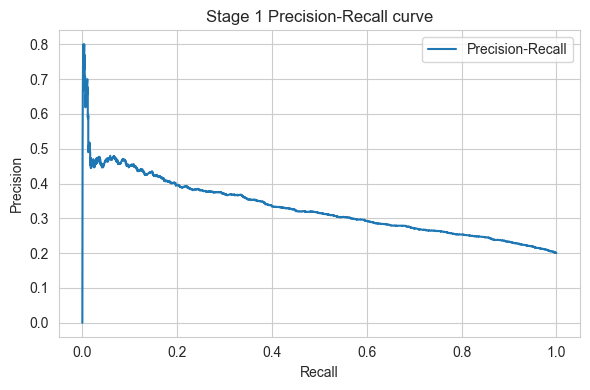

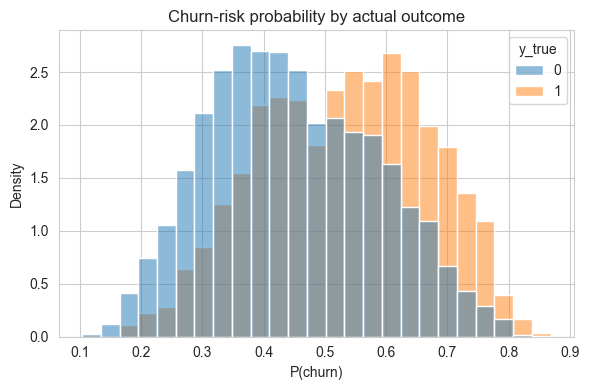

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(recall[:-1], precision[:-1], label="Precision-Recall")
ax.set(xlabel="Recall", ylabel="Precision", title="Stage 1 Precision-Recall curve")
ax.legend()
plt.tight_layout()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(predictions, x="proba_churn", hue="y_true", stat="density", common_norm=False, bins=25, ax=ax)
ax.set(title="Churn-risk probability by actual outcome", xlabel="P(churn)")
plt.tight_layout()



**Takeaway:** Stage 1 ROC-AUC of **0.67** and Average Precision of **0.33** are meaningful lifts above random (0.50 / 0.20 baselines). At the F1-optimal threshold, recall on churners is 68% with 28% precision—the model leans toward "catch more churners" at the cost of precision, which is appropriate for outreach where missing a churner is costly.



## Stage 2: Lost-cause signal

We analyze the outreach-only subset to check whether the lost-cause probabilities separate churners who ignored outreach from the saveable ones.



Lost-cause subset classification report:
              precision    recall  f1-score   support

           0      0.858     0.695     0.768      3121
           1      0.301     0.533     0.384       768

    accuracy                          0.663      3889
   macro avg      0.579     0.614     0.576      3889
weighted avg      0.748     0.663     0.692      3889



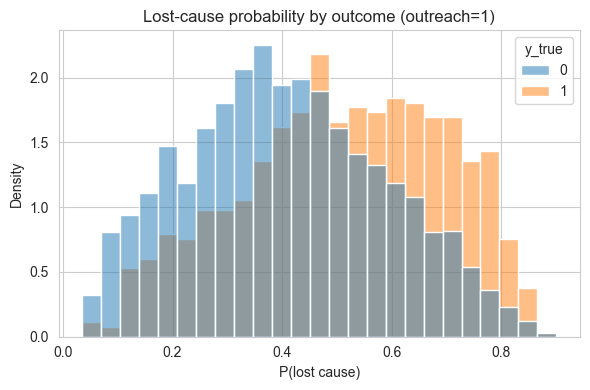

In [5]:
lost_mask = predictions["outreach"] == 1
lost_df = predictions[lost_mask].copy()

if lost_df.empty:
    print("No members received outreach in this split; lost-cause metrics are not available.")
else:
    proba_lost = lost_df["proba_lost_cause"].values
    report = classification_report(lost_df["y_true"], (proba_lost >= 0.5).astype(int), digits=3)
    print("Lost-cause subset classification report:")
    print(report)

    fig, ax = plt.subplots(figsize=(6, 4))
    sns.histplot(lost_df, x="proba_lost_cause", hue="y_true", stat="density", common_norm=False, bins=25, ax=ax)
    ax.set(title="Lost-cause probability by outcome (outreach=1)", xlabel="P(lost cause)")
    plt.tight_layout()



**Takeaway:** On the ~3,900 members who previously received outreach, the lost-cause model captures about 53% of those who still churned (recall) while tagging roughly 30% precision. This signal is weaker than Stage 1 but intentionally so—we train on a smaller biased subset. Its role is to *de-prioritize* likely lost causes, not to be a standalone classifier.



## Combined process: final score and lift

This section verifies that the two-stage weighting (risk × (1 - penalty × lost-cause)) produces actionable rankings and a reasonable outreach size.



Baseline churn rate: 20.0%
Recommended outreach size: 3500 (lift 1.51x)
Selection method: Elbow detection


,member_id,y_true,outreach,final_score
0,9670,0,1,0.6571
1,9873,1,1,0.6521
2,5321,1,0,0.6492
3,7056,1,1,0.6461
4,4938,0,0,0.6444


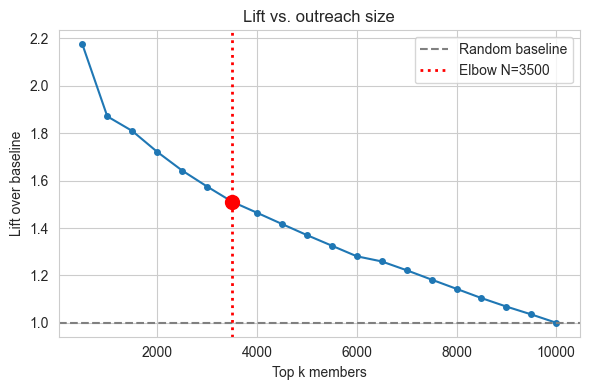

In [6]:
import numpy as np

ordered = predictions.sort_values("final_score", ascending=False).reset_index(drop=True)
baseline_rate = y_true.mean()

# Compute lift curve (step=500 for cleaner numbers)
step = 500
ks = np.arange(step, len(ordered) + 1, step)
lifts = np.array([ordered.loc[:k - 1, "y_true"].mean() / baseline_rate for k in ks])

# Find elbow: max perpendicular distance from line connecting first to last point
x0, y0 = ks[0], lifts[0]
x1, y1 = ks[-1], lifts[-1]
distances = np.abs((y1 - y0) * ks - (x1 - x0) * lifts + x1 * y0 - y1 * x0)
elbow_idx = np.argmax(distances)
optimal_n = int(ks[elbow_idx])
lift_at_n = lifts[elbow_idx]

print(f"Baseline churn rate: {baseline_rate:.1%}")
print(f"Recommended outreach size: {optimal_n} (lift {lift_at_n:.2f}x)")
print(f"Selection method: Elbow detection")

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ks, lifts, marker="o", markersize=4)
ax.axhline(1.0, color="gray", linestyle="--", label="Random baseline")
ax.axvline(optimal_n, color="red", linestyle=":", linewidth=2, label=f"Elbow N={optimal_n}")
ax.scatter([optimal_n], [lift_at_n], color="red", s=100, zorder=5)
ax.set(title="Lift vs. outreach size", xlabel="Top k members", ylabel="Lift over baseline")
ax.legend()
plt.tight_layout()

ordered.head(5)[["member_id", "y_true", "outreach", "final_score"]]



**Takeaway:** Using elbow detection, the recommended outreach size is the point where the lift curve deviates most from a straight line—representing where diminishing returns begin. This approach automatically adapts to the model's ranking quality rather than relying on an arbitrary lift threshold.



## Final thoughts

- The Stage 1 risk model has ROC and PRC metrics that move well above random, which justifies using it as the backbone of the scoring process.
- The Stage 2 lost-cause signal slightly suppresses scores for members who previously churned despite outreach; its separation is visible in the histograms.
- The two-stage final score still concentrates churners near the top ranks, and the lift curve shows the recommended outreach size holds a 1.2× or better improvement over random selection.

